In [ ]:
# import every subjects' trial setup (t1-t17)
# apply df_process trials
# function to get lie detection accuracies at each parameter level for given model
# plot results

In [1]:
import json
import pandas as pd
import seaborn as sns
import regex as re

from scripts.analysis import *
from scripts.data_processing import process_trials_from_df

In [2]:
import os

files = os.listdir('./data/fr/')

# print(files)

foi = []
for file in files:
    if file.endswith(".feather") & file.startswith("fr_batch1"):
        foi.append(os.path.join("./data/fr/", file))
    else:
        continue

print(foi)

['./data/fr/fr_batch1_56210effed6e5a000ac7f3a5.feather', './data/fr/fr_batch1_57313ba2070de6000f43384e.feather', './data/fr/fr_batch1_5af196e1e1b5b8000148ac76.feather', './data/fr/fr_batch1_5cd5fe480f0de600018e7251.feather', './data/fr/fr_batch1_5fec7577ad8fbadf15cd5607.feather', './data/fr/fr_batch1_60f44f7a57468d4e9f87fa5b.feather', './data/fr/fr_batch1_61085b8ec672d0e88151d5ae.feather', './data/fr/fr_batch1_6110e7ae08023ecb9207b05e.feather', './data/fr/fr_batch1_6147d726fa94eb7d5c2de156.feather', './data/fr/fr_batch1_614f23537aab4e64abfd53ae.feather', './data/fr/fr_batch1_6152218517a89c5b41e18a06.feather', './data/fr/fr_batch1_61533356ce435e5a4a4addd0.feather', './data/fr/fr_batch1_6154284fc5154abb9a264b0c.feather', './data/fr/fr_batch1_6156ee007bdef87eb5b4aeb0.feather', './data/fr/fr_batch1_615d9f86fdd5e127d783e850.feather', './data/fr/fr_batch1_615ec4f34cb81d7e58fa144c.feather', './data/fr/fr_batch1_615f0726cbd12330a2d82556.feather', './data/fr/fr_batch1_615f1500b60d25e2660e8644.f

In [3]:
# get all DF filenames from data/fr folder

def data_to_df(files: list):
    ''' provide list of feather data file pathnames '''
    dfs = {}  # features of interest
    for path in files:
        try:
            print(path)
            df = pd.read_feather(path)
            uuid = re.findall('(?<=fr_batch1_).*(?=\.feather)', path)[0]
            dfs[uuid] = df
        except PermissionError:
            continue
    return dfs

In [4]:
dfs = data_to_df(foi)

./data/fr/fr_batch1_56210effed6e5a000ac7f3a5.feather
./data/fr/fr_batch1_57313ba2070de6000f43384e.feather
./data/fr/fr_batch1_5af196e1e1b5b8000148ac76.feather
./data/fr/fr_batch1_5cd5fe480f0de600018e7251.feather
./data/fr/fr_batch1_5fec7577ad8fbadf15cd5607.feather
./data/fr/fr_batch1_60f44f7a57468d4e9f87fa5b.feather
./data/fr/fr_batch1_61085b8ec672d0e88151d5ae.feather
./data/fr/fr_batch1_6110e7ae08023ecb9207b05e.feather
./data/fr/fr_batch1_6147d726fa94eb7d5c2de156.feather
./data/fr/fr_batch1_614f23537aab4e64abfd53ae.feather
./data/fr/fr_batch1_6152218517a89c5b41e18a06.feather
./data/fr/fr_batch1_61533356ce435e5a4a4addd0.feather
./data/fr/fr_batch1_6154284fc5154abb9a264b0c.feather
./data/fr/fr_batch1_6156ee007bdef87eb5b4aeb0.feather
./data/fr/fr_batch1_615d9f86fdd5e127d783e850.feather
./data/fr/fr_batch1_615ec4f34cb81d7e58fa144c.feather
./data/fr/fr_batch1_615f0726cbd12330a2d82556.feather
./data/fr/fr_batch1_615f1500b60d25e2660e8644.feather
./data/fr/fr_batch1_6160011304f5319ece189bfa.f

In [5]:
uuids = dfs.keys()

In [6]:
def lie_detection_accuracy(actual_lies, model_pred, prior, alpha, threshold):
    if len(actual_lies) != len(model_pred):
        raise ValueError("Unequal number of predicted and actual data points")
    
    pre = [prior + alpha*v for v in model_pred]
    pred = [1 if v > threshold else 0 for v in pre]
    
    tp = [1 if (x==1) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    tp = sum(tp)
    
    fp = [1 if (x==0) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    fp = sum(fp)
    
    tn = [1 if (x==0) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    tn = sum(tn)
    
    fn = [1 if (x==1) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    fn = sum(fn)
    
    accuracy = (tp + tn)/len(actual_lies)
    
    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    
    f1 = tp/(tp+0.5*(fp+fn))
    
    return {"n_subjective_detection": tp+fp, 
                           "tp": tp, 
                           "fp": fp, 
                           "tn": tn, 
                           "fn": fn, 
                           "precision": precision, 
                           "recall": recall, 
                           "accuracy": accuracy, 
                           "f1": f1}


def lie_detection_accuracy_opt(actual_lies, model_pred, prior, alpha, threshold):
    if len(actual_lies) != len(model_pred):
        raise ValueError("Unequal number of predicted and actual data points")
    
    pre = [prior + alpha*v for v in model_pred]
    pred = [1 if v < threshold else 0 for v in pre]
    
    tp = [1 if (x==1) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    tp = sum(tp)
    
    fp = [1 if (x==0) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    fp = sum(fp)
    
    tn = [1 if (x==0) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    tn = sum(tn)
    
    fn = [1 if (x==1) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    fn = sum(fn)
    
    accuracy = (tp + tn)/len(actual_lies)
    
    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    
    f1 = tp/(tp+0.5*(fp+fn))
    
    return {"n_subjective_detection": tp+fp, 
                           "tp": tp, 
                           "fp": fp, 
                           "tn": tn, 
                           "fn": fn, 
                           "precision": precision, 
                           "recall": recall, 
                           "accuracy": accuracy, 
                           "f1": f1}

In [7]:
list(dfs['615d9f86fdd5e127d783e850'])

['PID',
 'n_red',
 'outcome',
 'col_reported',
 'col_picked',
 'pp_lied',
 'RT_rating',
 'win_lose_tie',
 'suspicion_rating']

In [8]:
n_blue_per_trial = reset_n_blue_per_trial()

In [9]:
# use threshold 0.5

obj_detection_blue_is_lie = []
obj_detection_lied_is_lie = []
obj_detection_col_congruency = [] # detect lie when other player reports different colour from subject's colour pick

obj_detection_sig_ev_noup = []
obj_detection_unsig_ev_noup = []
obj_detection_sig_col_count = []
obj_detection_unsig_col_count = []
obj_detection_sig_ev_up = []
obj_detection_unsig_ev_up = []

obj_detection_optimal_prob = []

for uuid in uuids:
    df = process_trials_from_df(dfs[uuid], 7)
    subject_lied = df['col_reported']!=df['col_picked']
    col_congruency = df['outcome']!=df['col_picked']
    
    optimal_p = []
    for row in df.values:
        optimal_p.append(check_lie_prob_signed(n_blue_per_trial, 7, row[1], row[2]))
    n_blue_per_trial = reset_n_blue_per_trial()

    obj_detection_blue_is_lie.append(lie_detection_accuracy(df['pp_lied'].values, df['outcome'].values, 0, 1, 0.5))
    obj_detection_lied_is_lie.append(lie_detection_accuracy(df['pp_lied'].values, subject_lied.values, 0, 1, 0.5))
    obj_detection_col_congruency.append(lie_detection_accuracy(df['pp_lied'].values, col_congruency.values, 0, 1, 0.5))
    
    obj_detection_sig_ev_noup.append(lie_detection_accuracy(df['pp_lied'].values, df['normed_signed_e_v'].values, 0, 1, 0.5))
    obj_detection_unsig_ev_noup.append(lie_detection_accuracy(df['pp_lied'].values, df['normed_unsigned_e_v'].values, 0, 1, 0.5))
    
    obj_detection_sig_col_count.append(lie_detection_accuracy(df['pp_lied'].values, df['normed_signed_colour_count'].values, 0, 1, 0.5))
    obj_detection_unsig_col_count.append(lie_detection_accuracy(df['pp_lied'].values, df['normed_unsigned_colour_count'].values, 0, 1, 0.5))
    
    obj_detection_sig_ev_up.append(lie_detection_accuracy(df['pp_lied'].values, df['normed_cs_signed_e_v'].values, 0, 1, 0.5))
    obj_detection_unsig_ev_up.append(lie_detection_accuracy(df['pp_lied'].values, df['normed_cs_unsigned_e_v'].values, 0, 1, 0.5))
    
    obj_detection_optimal_prob.append(lie_detection_accuracy_opt(df['pp_lied'].values, optimal_p, 0, 1, 0.05))

n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
n trials with setup 2
n trials with setup 2
n trials with setup 1
n trials with setup 2
n trials with setup 3
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 3
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 5
n trials with setup 6
n trials with setup 5
n trials with setup 6
n trials with setup 2
n trials with setup 7
n trials with setup 7
n trials with setup 8
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 9
n trials with setup 5
n trials with setup 6
n trials with setup 8
n trials with setup 7
n trials with setup 8
n trials with setup 10
n trials with setup 7
n trials with setup 9
n trials with setup 10

n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 1
n trials with setup 2
n trials with setup 1
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 3
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 5
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 7
n trials with setup 6
n trials with setup 8
n trials with setup 4
n trials with setup 6
n trials with setup 5
n trials with setup 7
n trials with setup 7
n trials with setup 2
n trials with setup 3
n trials with setup 8
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 9
n trials with setup 7
n trials with setup 6
n

n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 1
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 3
n trials with setup 7
n trials with setup 2
n trials with setup 3
n trials with setup 2
n trials with setup 4
n trials with setup 4
n trials with setup 5
n trials with setup 5
n trials with setup 8
n trials with setup 6
n trials with setup 9
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 10
n trials with setup 11
n trials with setup 7
n trials with setup 3
n trials with setup 4
n trials with setup 2
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 12
n trials with setup 2
n trials with setup 5
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 7
n tria

n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 4
n trials with setup 2
n trials with setup 5
n trials with setup 3
n trials with setup 6
n trials with setup 4
n trials with setup 7
n trials with setup 1
n trials with setup 2
n trials with setup 4
n trials with setup 5
n trials with setup 3
n trials with setup 5
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 4
n trials with setup 5
n trials with setup 2
n trials with setup 6
n trials with setup 7
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 3
n trials with setup 7
n trials with setup 8
n trials with setup 8
n trials with setup 9
n trials with setup 10
n trials with setup 2
n trials 

In [10]:
pd.DataFrame(obj_detection_blue_is_lie)

,n_subjective_detection,tp,fp,tn,fn,precision,recall,accuracy,f1
0,67,29,38,22,1,0.432836,0.966667,0.566667,0.597938
1,70,27,43,19,1,0.385714,0.964286,0.511111,0.551020
2,66,26,40,24,0,0.393939,1.000000,0.555556,0.565217
3,50,3,47,38,2,0.060000,0.600000,0.455556,0.109091
4,50,10,40,39,1,0.200000,0.909091,0.544444,0.327869
5,54,6,48,33,3,0.111111,0.666667,0.433333,0.190476
6,70,30,40,20,0,0.428571,1.000000,0.555556,0.600000
7,41,9,32,48,1,0.219512,0.900000,0.633333,0.352941
8,49,11,38,39,2,0.224490,0.846154,0.555556,0.354839
9,70,30,40,18,2,0.428571,0.937500,0.533333,0.588235


<AxesSubplot:ylabel='precision'>

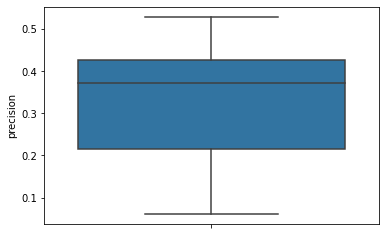

In [12]:
sns.boxplot(data=pd.DataFrame(obj_detection_blue_is_lie), y="precision")

In [59]:
pd.DataFrame(obj_detection_blue_is_lie).apply(lambda x: sum(x)/len(x))

n_subjective_detection    60.650000
tp                        20.450000
fp                        40.200000
tn                        28.150000
fn                         1.200000
precision                  0.318640
recall                     0.908325
accuracy                   0.540000
f1                         0.461697
dtype: float64

In [80]:
pd.DataFrame(obj_detection_lied_is_lie).apply(lambda x: sum(x)/len(x))

n_subjective_detection    21.600000
tp                         5.350000
fp                        16.250000
tn                        52.100000
fn                        16.300000
precision                  0.200944
recall                     0.242281
accuracy                   0.638333
f1                         0.179640
dtype: float64

In [78]:
pd.DataFrame(obj_detection_col_congruency).apply(lambda x: sum(x)/len(x))

n_subjective_detection    39.350000
tp                        13.000000
fp                        26.350000
tn                        42.000000
fn                         8.650000
precision                  0.321418
recall                     0.567187
accuracy                   0.611111
f1                         0.394334
dtype: float64

In [63]:
pd.DataFrame(obj_detection_sig_col_count).apply(lambda x: sum(x)/len(x))

n_subjective_detection    28.750000
tp                         7.700000
fp                        21.050000
tn                        47.300000
fn                        13.950000
precision                  0.317492
recall                     0.435722
accuracy                   0.611111
f1                         0.299409
dtype: float64

In [64]:
pd.DataFrame(obj_detection_unsig_col_count).apply(lambda x: sum(x)/len(x))

n_subjective_detection    16.650000
tp                         4.250000
fp                        12.400000
tn                        55.950000
fn                        17.400000
precision                  0.283370
recall                     0.195456
accuracy                   0.668889
f1                         0.204908
dtype: float64

In [65]:
pd.DataFrame(obj_detection_sig_ev_noup).apply(lambda x: sum(x)/len(x))

n_subjective_detection    59.950000
tp                        20.350000
fp                        39.600000
tn                        28.750000
fn                         1.300000
precision                  0.322020
recall                     0.904479
accuracy                   0.545556
f1                         0.464205
dtype: float64

In [66]:
pd.DataFrame(obj_detection_unsig_ev_noup).apply(lambda x: sum(x)/len(x))

n_subjective_detection    44.750000
tp                        18.150000
fp                        26.600000
tn                        41.750000
fn                         3.500000
precision                  0.385816
recall                     0.810740
accuracy                   0.665556
f1                         0.508400
dtype: float64

In [83]:
pd.DataFrame(obj_detection_sig_ev_up).apply(lambda x: sum(x)/len(x))

n_subjective_detection    48.100000
tp                        11.550000
fp                        36.550000
tn                        31.800000
fn                        10.100000
precision                  0.247327
recall                     0.550666
accuracy                   0.481667
f1                         0.319751
dtype: float64

In [82]:
pd.DataFrame(obj_detection_unsig_ev_up).apply(lambda x: sum(x)/len(x))

n_subjective_detection    46.350000
tp                        11.400000
fp                        34.950000
tn                        33.400000
fn                        10.250000
precision                  0.246408
recall                     0.533070
accuracy                   0.497778
f1                         0.319328
dtype: float64

In [95]:
pd.DataFrame(obj_detection_optimal_prob).apply(lambda x: sum(x)/len(x))

n_subjective_detection    22.650000
tp                        12.050000
fp                        10.600000
tn                        57.750000
fn                         9.600000
precision                  0.441724
recall                     0.474506
accuracy                   0.775556
f1                         0.452494
dtype: float64